# Ordinary Least Squares - Bootstrapping Simulations

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16}) 
plt.style.use('dark_background')
import savingfigR as sf 
import scipy.stats as stats
import numba as nb 

In [2]:
class OLS_wboot():
    def __init__(self, x, y, b0_true, b1_true, n_boots=1000000):
        # properties 
        self.x = x
        self.y = y
        self.b0_true = b0_true
        self.b1_true = b1_true
        self.n_boots = n_boots
        self.b0 = []
        self.b1 = []
        self.b0_boot = np.empty(self.n_boots)
        self.b1_boot = np.empty(self.n_boots)
        self.line4plot = [] 
        self.residuals = [] 

        # function calls 
        self.calculateB1()
        self.calculateB0()
        self.calculateFitLine()
        self.visualizeOriginalFit()
        self.calculateResiduals()
        self.bootB0B1()
        self.visualizeBootstrappedBetas()

    ## calculations 
    def calculateB0(self, x=[], y=[], b1=[], nargout=0):
        if len(x) == 0 and len(y) == 0 and len(b1) == 0:
            x = self.x
            y = self.y
            b1 = self.b1
        b0 = np.mean(y) - b1 * np.mean(x)
        if nargout == 0:
            self.b0 = b0
        else : 
            return b0

    def calculateB1(self, x=[], y=[], nargout=0):
        if len(x) == 0 and len(y) == 0:
            x = self.x
            y = self.y
        b1 = np.dot(x - np.mean(x), y - np.mean(y)) / np.sum((x - np.mean(x))**2)
        if nargout == 0 :
            self.b1 = b1    
        else : 
            return b1

    def calculateFitLine(self):
        x = np.linspace(np.min(self.x), np.max(self.x), 1000)
        y = self.b0 + self.b1 * x
        self.line4plot = np.array([x, y])

    def calculateResiduals(self):
        self.residuals = self.y - (self.b0 + self.b1 * self.x)

    ## bootstrapping
    def bootB0B1(self):
        self.b1_boot, self.b0_boot = self.bootResiduals(self.n_boots, self.residuals, self.x, self.y)

    @staticmethod
    @nb.njit(parallel=True)
    def bootResiduals(n_boots, residuals, x, y):
        b1_boot = np.empty(n_boots)
        b0_boot = np.empty(n_boots)
        for i in nb.prange(n_boots):
            rnd_resids = np.random.choice(residuals, np.shape(residuals), replace=True) # randomly sample some residuals
            y_booti = y + rnd_resids # add to current y-values 
            b1_boot[i] = np.dot(x - np.mean(x), y_booti - np.mean(y_booti)) / np.sum((x - np.mean(x))**2)
            b0_boot[i] = np.mean(y_booti) - b1 * np.mean(x)
        return b1_boot, b0_boot 

    ## visualiazations 
    def visualizeOriginalFit(self):
        plt.figure()
        plt.scatter(self.x, self.y)
        plt.plot(self.line4plot[0,:], self.line4plot[1,:], c='r')
        plt.xlabel('X') 
        plt.ylabel('Y')
        plt.title('Original data and fit')
        plt.show()

    def visualizeResiduals(self):
        plt.figure()
        plt.scatter(self.x, self.residuals)
        plt.axhline(0)
        plt.xlabel('X')
        plt.ylabel('Actual - predicted')
        plt.show()

    def visualizeBootstrappedBetas(self):
        fig = plt.figure(figsize=(13,5))
        plt.subplot(1,2,1)
        n0, bins0, _ = plt.hist(self.b0_boot)
        plt.axvline(self.b0_true, label='True')
        plt.axvline(bins0[n0.argmax()], ls='--', c='mediumslateblue', label='Boot Mode')
        plt.axvline(np.mean(self.b0_boot), ls='--', c='salmon', label='Boot Mean')
        plt.xlabel('b0')
        plt.ylabel('Frequency')
        plt.legend(loc=0)
        plt.subplot(1,2,2)
        n1, bins1, _ =plt.hist(self.b1_boot)
        plt.axvline(self.b1_true, label='True')
        plt.axvline(bins1[n1.argmax()], ls = '--', c='mediumslateblue', label='Boot Mode')
        plt.axvline(np.mean(self.b1_boot), ls='--', c='salmon', label='Boot Mean')
        plt.xlabel('b1')
        plt.legend(loc=0)

        fig.suptitle('Bootstrapped parameters')
        plt.tight_layout()
        plt.show()


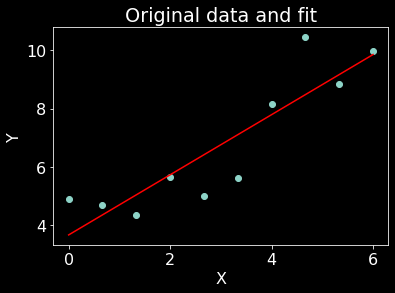

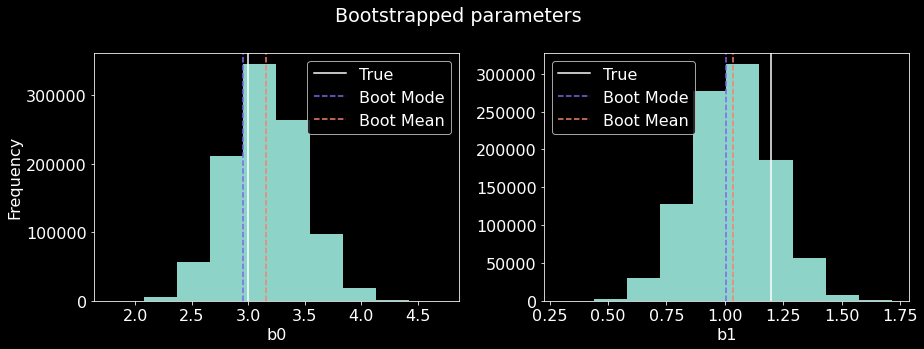

In [3]:
# generate some data 
b0, b1 = 3, 1.2
x = np.linspace(0, 6, 10)
y = (b0 + b1 * x) + np.random.normal(0, 1, len(x))

ols1 = OLS_wboot(x, y, b0, b1)